In [3]:
import numpy as np  
import pandas as pd  
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm 
import matplotlib.pyplot as plt  
%matplotlib inline

**Define Black Scholes model**

$$
d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

$$
d_2 = d_1 - s \cdot \sqrt{t} = \frac{\ln(\frac{S}{K}) + (r - \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

$$
\textbf{C} = SN(d_1) - Ke^{-rt}N(d_2) 
$$

In [5]:
def d1(S, K, r, stdev, T):
    return (np.log(S / K) + (r + stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))
 
def d2(S, K, r, stdev, T):
    return (np.log(S / K) + (r - stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))

In [7]:
def BSM(S, K, r, stdev, T):
        return (S * norm.cdf(d1(S, K, r, stdev, T))) - (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, stdev, T)))

**Download market data**

In [9]:
ticker = "MSFT"
strike_delta = 0.1 # e.g. 0.1 represents 10%

end_date = datetime.today().date()
start_date = end_date - timedelta(days=365)

data = yf.download('MSFT', start=start_date, end=end_date)["Close"]

strike = data.iloc[-1] * (1 * (1 + strike_delta))
strike = strike.values

C:\Users\sabbi\AppData\Local\Temp\ipykernel_36500\3793182473.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('MSFT', start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


In [11]:
log_returns = np.log(1 + data.pct_change())

In [13]:
log_returns # check timeseries download

Ticker,MSFT
Date,
2024-08-30,NaN
2024-09-03,-0.018632
2024-09-04,-0.001320
2024-09-05,-0.001248
2024-09-06,-0.016517
...,...
2025-08-25,-0.005873
2025-08-26,-0.004412
2025-08-27,0.009318


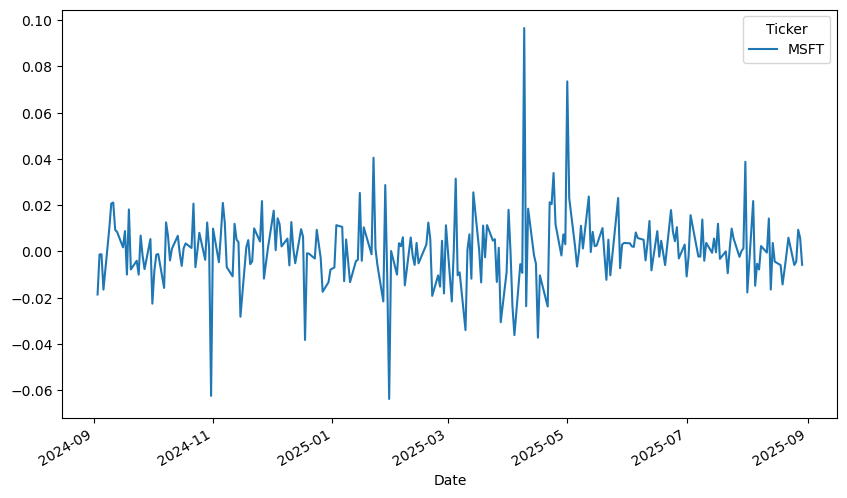

In [15]:
log_returns.plot(figsize=(10, 6));
plt.show()

In [17]:
stdev = log_returns.std() * 250 ** 0.5
stdev

Ticker
MSFT    0.246366
dtype: float64

In [19]:
ticker = yf.Ticker("SR3=F") # use 3 month SOFR Futures via CME Group as proxy for the risk free rate
rfr_data = ticker.history(period="1y")[["Close"]]
rfr_data["Risk Free Rate"] = 100 - rfr_data["Close"]
rfr_data

,Close,Risk Free Rate
Date,,
2025-08-29 00:00:00-04:00,95.904999,4.095001


In [21]:
risk_free_rate_value = float(rfr_data["Risk Free Rate"].iloc[-1])/100
risk_free_rate_value

0.04095001220703125

In [23]:
r = risk_free_rate_value
K = strike[0]
T = 1         # e.g. 1 represents 1 year

In [25]:
S = data.iloc[-1]
S

Ticker
MSFT    506.690002
Name: 2025-08-29 00:00:00, dtype: float64

In [27]:
d1(S, K, r, stdev, T)

Ticker
MSFT   -0.097464
dtype: float64

In [29]:
d2(S, K, r, stdev, T)

Ticker
MSFT   -0.343831
dtype: float64

In [31]:
option_price = BSM(S, K, r, stdev, T)
c = option_price.iloc[0]
print(f"The call option price is {c:0.2f}")
print(f"The spot price is {S.iloc[-1]:0.2f}")
print(f"The risk free rate is {r*100:0.2f}%")
print(f"The strike is {K:0.2f}")
print(f"The expiry date is {T:0.2f} year.")

The call option price is 38.14
The spot price is 506.69
The risk free rate is 4.10%
The strike is 557.36
The expiry date is 1.00 year.
